Imports

In [15]:
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Load in the DataFrame

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [39]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [40]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


Start by doing the WRONG thing

Trying to predict the price itself

In [41]:
series = df['close'].values.reshape(-1, 1)

Normalize the data

Note: I didn't think where the true boundary is, this is just approx

In [42]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

Build the dataset

let's see if we can use T past values to predict the next value

In [43]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  X.append(series[t:t+T])
  Y.append(series[t+T])

X = np.array(X).reshape(-1, T, 1) # N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)



Try autoregressive RNN model

In [44]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1)
)

Train the model

In [46]:
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 1s 37ms/step - loss: 0.0251 - val_loss: 0.0322
Epoch 2/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0219
Epoch 3/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0063 - val_loss: 0.0197
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0062 - val_loss: 0.0177
Epoch 5/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0307
Epoch 6/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0198
Epoch 7/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0062 - val_loss: 0.0168
Epoch 8/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0366
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0221
Epoch 10/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0202
Epoch 11/

Plot loss per iteration

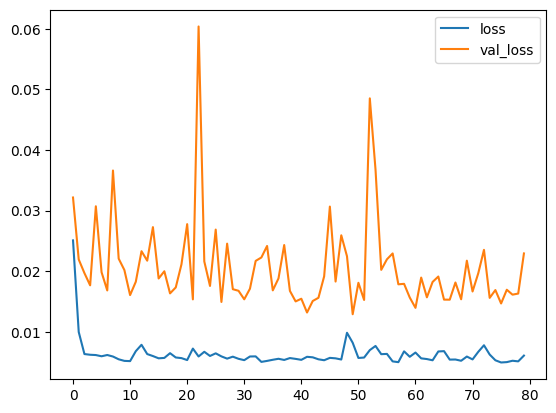

In [47]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

One-step forecast using true targets

In [48]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

40/40 [==============================] - 1s 4ms/step
(1249, 1)


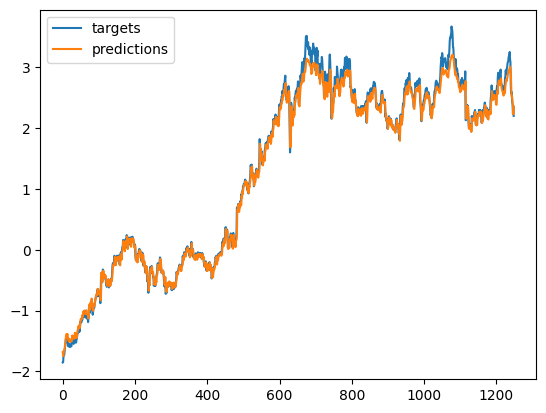

In [49]:
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend();

Multi-step forecast

1/1 [==============================] - 0s 23ms/step


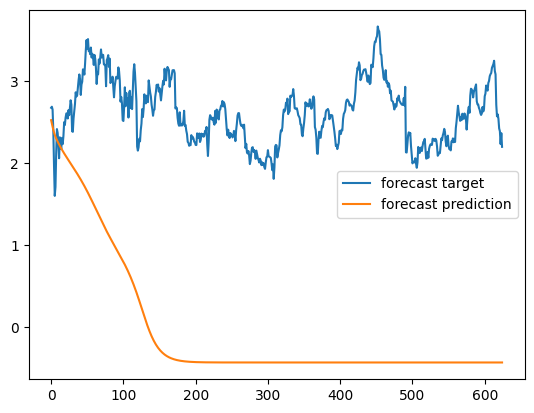

In [50]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

Calculate the returns by first shifting the data

In [51]:
df['prev_close'] = df['close'].shift(1) # move everyting up 1

# close / prev close
# x[2]    x[1]
# x[3]    x[2]

In [52]:
df.head()

,date,open,high,low,close,volume,Name,prev_close
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


Then the return is

$(x(t) - x(t - 1)) / x(t-1)$

In [53]:
df['return'] = (df['close'] - df['prev_close']) / df['prev_close']

In [54]:
df.head()

,date,open,high,low,close,volume,Name,prev_close,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<Axes: >

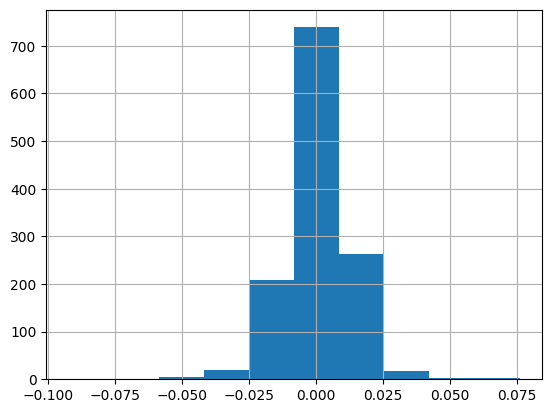

In [55]:
df['return'].hist()

Normalize the data

In [57]:
series = df['return'].values[1:].reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

Build the dataset

In [58]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  X.append(series[t:t+T])
  Y.append(series[t+T])

X = np.array(X).reshape(-1, T, 1) # N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


Try autoregressive RNN model

In [67]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.01)
)

In [68]:
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
20/20 [==============================] - 6s 39ms/step - loss: 1.0007 - val_loss: 1.1457
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9956 - val_loss: 1.1266
Epoch 3/80
20/20 [==============================] - 0s 12ms/step - loss: 0.9866 - val_loss: 1.1379
Epoch 4/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9862 - val_loss: 1.1301
Epoch 5/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9848 - val_loss: 1.1395
Epoch 6/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9884 - val_loss: 1.1480
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9884 - val_loss: 1.1330
Epoch 8/80
20/20 [==============================] - 0s 12ms/step - loss: 0.9800 - val_loss: 1.1526
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.9757 - val_loss: 1.1502
Epoch 10/80
20/20 [==============================] - 0s 11ms/step - loss: 0.9723 - val_loss: 1.1515
Epoch 11/

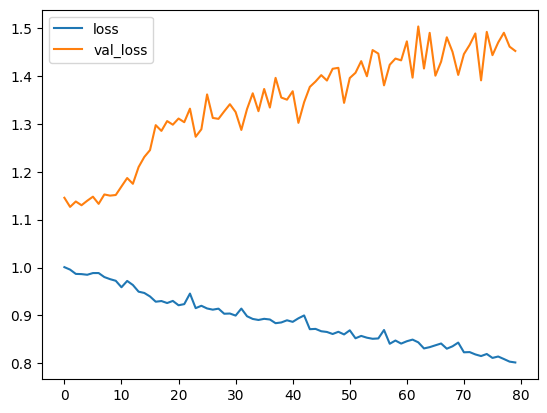

In [69]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

One-step forecast using true targets

39/39 [==============================] - 1s 5ms/step
(1248, 1)


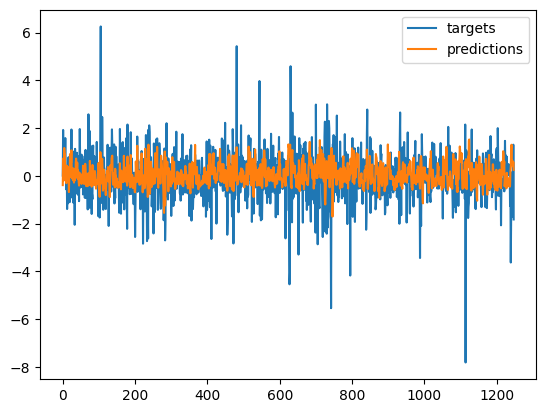

In [70]:
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend();


Multi-step forecast

1/1 [==============================] - 0s 24ms/step


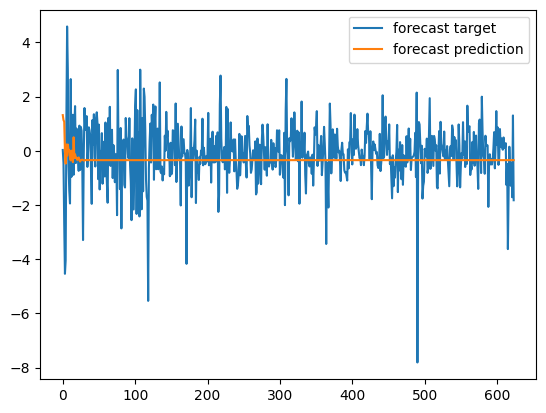

In [71]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

Now turn the full data into numpy arrays

Not yet in the final X format


In [72]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['return'].values

Now make the actual data which will go into the neural network

In [73]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

Normalize the inputs

In [75]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

Setup X_train and Y_train

In [80]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)
for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

Setup X_test and Y_test

In [77]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0 ... (N - Ntrain)
  # t counts from Ntrain ... N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

Make the RNN

In [78]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

Train the RNN

In [81]:
r = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=32,
    epochs=300
)

Epoch 1/300
27/27 [==============================] - 3s 34ms/step - loss: 0.7012 - accuracy: 0.4791 - val_loss: 0.6947 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6940 - accuracy: 0.5209 - val_loss: 0.6954 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6951 - accuracy: 0.5280 - val_loss: 0.6962 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.5197 - val_loss: 0.6957 - val_accuracy: 0.4927
Epoch 5/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6930 - accuracy: 0.5077 - val_loss: 0.6977 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6917 - accuracy: 0.5244 - val_loss: 0.6910 - val_accuracy: 0.5293
Epoch 7/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6915 - accuracy: 0.5244 - val_loss: 0.6914 - val_accuracy: 0.5244
Epoch 

Plot the loss

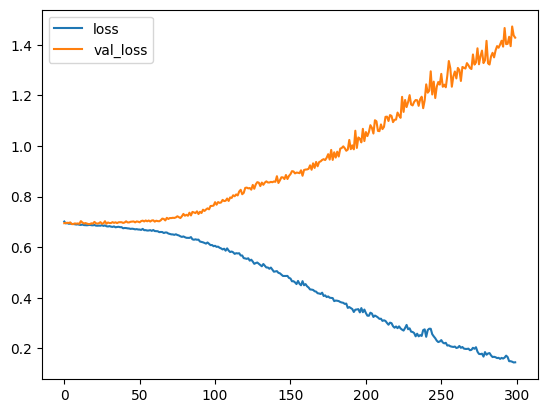

In [82]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

Plot the accuracy

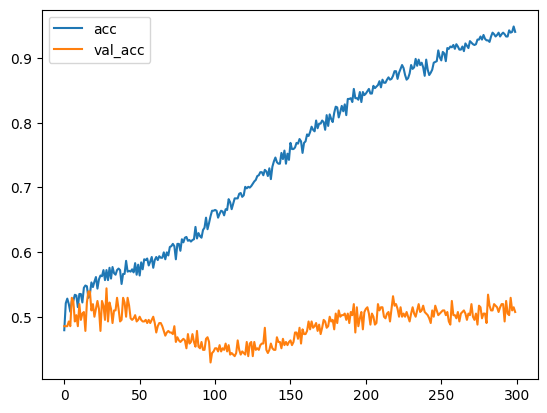

In [83]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend();